In [2]:
import pandas as pd
import obspy 
import os
import re
import logging
import obspy.signal.interpolation as itp
import obspy.core.stream 
import obspy.core.trace
from datetime import datetime
import numpy as np

#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))


In [199]:
os.getcwd()

'c:\\Users\\javie\\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\\MaestriaEnCienciaDeDatos\\EstanciaDeInvestigacion\\Popocatepelt\\PopocatepetlVolcano'

In [3]:
os.chdir("D:\\Popocatepetl")
os.getcwd()

'D:\\Popocatepetl'

In [4]:
paths = os.listdir("data/2023/01/01") 

folders =  os.listdir("data/2023/") 

letters = 'CN.PPPP'

with_s = [x for x in paths if re.match(r'^{}'.format(letters), x)]

folders

['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12']

In [5]:
len(with_s)

24

In [28]:
os.chdir(os.getcwd())

In [31]:
def complete_hour(trace_z):
    n = len(trace_z)
    for i in range(n):
        if i == 0:
            st_final = trace_z[i]
        else:
            st_final = obspy.Trace.__add__(self = st_final, trace = trace_z[i], fill_value='interpolate')
    return st_final

def create_empty_day(Year, Month, Day):
    array= np.zeros(360000)
    array = array.astype(float)

    st_start = obspy.core.trace.Trace(data = array)
    st_start.stats.starttime=f"{Year}-{Month}-{Day}T00:00:00Z"
    st_start.id = "CN.PPPP..HHZ"
    st_start.stats.delta = 0.01
    st_start.sampling_rate = 100

    st_end = obspy.core.trace.Trace(data = array)
    st_end.stats.starttime=f"{Year}-{Month}-{Day}T23:00:00Z"
    st_end.id = "CN.PPPP..HHZ"
    st_end.stats.delta = 0.01
    st_end.sampling_rate = 100

    st_final = obspy.Trace.__add__(self=st_start, trace=st_end , fill_value=0.0)

    return st_final

def complete_day(Year, Month, Day, paths_PPPP):
    k = 1
    for i in paths_PPPP:
        st = obspy.read("data/"+Year+"/"+Month+"/"+Day+"/"+i)
        st = st.select(component='Z')
        st = st.resample(sampling_rate=100)
        # Validate that we have only one measurement of component Z
        if len(st)==1:
            if k == 1:
                st_final = st[0]
            else:
                st_final2 = st[0]
                st_final = obspy.Trace.__add__(self=st_final, trace= st_final2, fill_value=0.0)
            k = k+1
        else:
            # Validate that we have measurements of component Z
            if len(st)>1:
                st = complete_hour(st)
                if k == 1:
                    st_final = st
                else:
                    st_final2 = st
                    st_final = obspy.Trace.__add__(self=st_final, trace= st_final2, fill_value=0.0)
                k = k+1
            else:
                st_final = create_empty_day(Year, Month, Day)
    
    if st_final.stats.starttime.hour != 0:

        array= np.zeros(360000)
        array = array.astype(float)
        st_start = obspy.core.trace.Trace(data = array)
        st_start.stats.starttime=f"{Year}-{Month}-{Day}T00:00:00Z"
        st_start.id = "CN.PPPP..HHZ"
        st_start.stats.delta = 0.01
        st_start.sampling_rate = 100

        st_final = obspy.Trace.__add__(self=st_start, trace=st_final , fill_value=0.0)
    
    if st_final.stats.endtime.hour != 23:
        
        array= np.zeros(360000)
        array = array.astype(float)
        st_end = obspy.core.trace.Trace(data = array)
        st_end.stats.starttime=f"{Year}-{Month}-{Day}T23:00:00Z"
        st_end.id = "CN.PPPP..HHZ"
        st_end.stats.delta = 0.01
        st_end.sampling_rate = 100

        st_final = obspy.Trace.__add__(self=st_final, trace=st_end , fill_value=0.0)

    return st_final


def data_day_processing(Year,Month,Day):
    paths = os.listdir("data/"+Year+"/"+Month+"/"+Day)
    paths_PPPP = [x for x in paths if re.match(r'^{}'.format('CN.PPPP'), x)]
    bandera = True
    # Validate if there exists a measure from the PPPP station for the day
    if len(paths_PPPP)>0: 
        # Validate that the day contains 24 hours
        if len(paths_PPPP)==24:
            i = 0
            while i < 24 and bandera:
                st = obspy.read("data/"+Year+"/"+Month+"/"+Day+"/"+paths_PPPP[i])
                st = st.select(component='Z')
                st = st.resample(sampling_rate=100)
                # Validate that we have only one measurement of component Z
                if len(st)==1:
                    # Validate that the hour measurement is complete
                    if st[0].stats.npts==360000:
                        if i == 0:
                            st_final = st[0]
                        else:
                            st_final = st_final + st[0]
                        i = i+1
                    else:
                        bandera = False
                        logging.error("El archivo "+i+" esta incompleto")
                else:
                    bandera = False
                    logging.error("No hay componente Z en el archivo "+i)

            if ~bandera:
                st_final = complete_day(Year, Month, Day, paths_PPPP)
    
            st_final.write("data/clean_data/"+Year+"/CN_PPPP_HHZ_"+Year+"_"+Month+"_"+Day+".seed", format = 'mseed') 
        else:
            logging.error("El dia no esta completo en el dia "+Year+"_"+Month+"_"+Day)
            st_final = complete_day(Year, Month, Day, paths_PPPP)
            st_final.write("data/clean_data/"+Year+"/CN_PPPP_HHZ_"+Year+"_"+Month+"_"+Day+".seed", format = 'mseed')
    else:
        logging.error("El dia "+Year+"_"+Month+"_"+Day+ "no tiene archivos para la estación PPPP")
        st_final = create_empty_day(Year, Month, Day)
        st_final.write("data/clean_data/"+Year+"/CN_PPPP_HHZ_"+Year+"_"+Month+"_"+Day+".seed", format = 'mseed')  

In [52]:
os.getcwd()

'C:\\Users\\LENOVO\\OneDrive\\Documentos\\Estancia de Investigación\\PopocatepetlVolcano'

In [35]:
Year, Month, Day = ("2023","08","07")
paths = os.listdir("data/"+Year+"/"+Month+"/"+Day)
paths_PPPP = [x for x in paths if re.match(r'^{}'.format('CN.PPPP'), x)]
st = complete_day(Year, Month, Day, paths_PPPP)

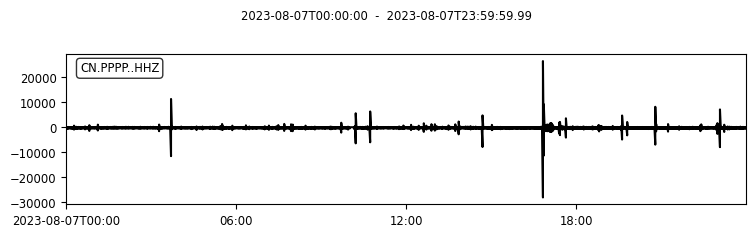

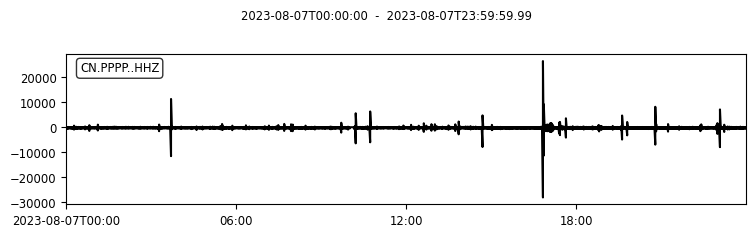

In [36]:
st.plot()

In [24]:
paths_PPPP

['CN.PPPP._20220404_000000.seed']

In [42]:
st = obspy.read("data/2023/11/09/CN.PPPP._20231109_170000.seed")


In [43]:
st = st.select(component='Z')
st

3 Trace(s) in Stream:
CN.PPPP..HHZ | 2023-11-09T17:00:00.000000Z - 2023-11-09T17:51:56.955000Z | 200.0 Hz, 623392 samples
CN.PPPP..HHZ | 2023-11-09T17:58:37.365000Z - 2023-11-09T17:59:13.715000Z | 200.0 Hz, 7271 samples
CN.PPPP..HHZ | 2023-11-09T17:59:14.595000Z - 2023-11-09T17:59:59.995000Z | 200.0 Hz, 9081 samples

In [169]:
st_final = st.select(component='Z')
st_final = st_final.resample(sampling_rate=100)

In [170]:
st_final[0]

CN.PPPP..HHZ | 2022-04-09T18:00:00.000000Z - 2022-04-09T23:59:59.990000Z | 100.0 Hz, 2160000 samples

In [9]:
st_final_complete = st_final.interpolate(sampling_rate = 100)

In [126]:
st_final

3 Trace(s) in Stream:
CN.PPPP..HHZ | 2022-02-22T18:00:00.000000Z - 2022-02-22T18:46:10.110000Z | 100.0 Hz, 277012 samples
CN.PPPP..HHZ | 2022-02-22T18:48:54.365000Z - 2022-02-22T18:49:34.705000Z | 100.0 Hz, 4035 samples
CN.PPPP..HHZ | 2022-02-22T18:49:35.400000Z - 2022-02-22T18:59:59.990000Z | 100.0 Hz, 62460 samples

In [9]:
len(st_final)



3

In [10]:
st_final_complete =st_final[0]+st_final[1]+ st_final[2]

In [127]:
aux1 =obspy.Trace.__add__(self=st_final[0], trace=st_final[1] , fill_value='interpolate')

In [128]:
st_final_complete = obspy.Trace.__add__(aux1, trace=st_final[2] , fill_value='interpolate')

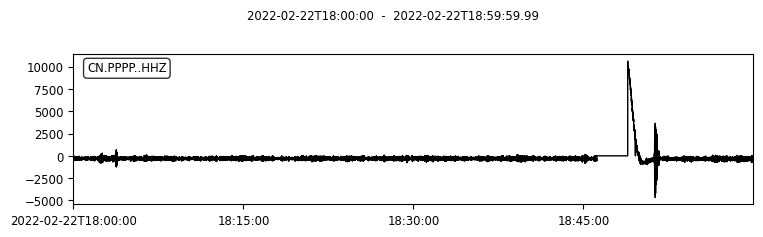

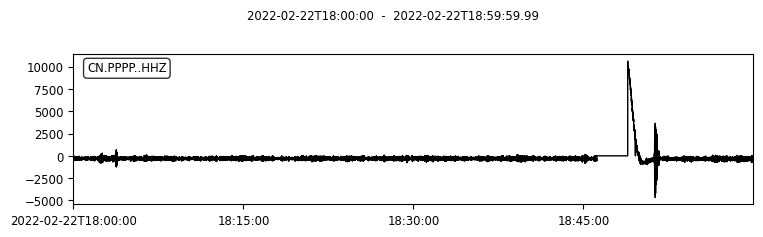

In [129]:
st_final_complete.plot()

In [15]:
st_final_complete

CN.PPPP..HHZ | 2022-02-22T18:00:00.000000Z - 2022-02-22T18:59:59.990000Z | 100.0 Hz, 360000 samples

In [22]:
len(st_final_complete)

360000

NotImplementedError: Trace with masked values found. This is not supported for this operation. Try the split() method on Trace/Stream to produce a Stream with unmasked Traces.

In [16]:
st_final_complete[277020]

-528.7854849518386

3 Trace(s) in Stream:
CN.PPPP..HHZ | 2022-02-22T18:00:00.000000Z - 2022-02-22T18:46:10.110000Z | 100.0 Hz, 277012 samples
CN.PPPP..HHZ | 2022-02-22T18:48:54.365000Z - 2022-02-22T18:49:34.695000Z | 100.0 Hz, 4034 samples
CN.PPPP..HHZ | 2022-02-22T18:49:35.400000Z - 2022-02-22T18:59:59.970000Z | 100.0 Hz, 62458 samples

In [120]:
277012+4034+62458

343504

In [41]:
st = obspy.read("data/2022/03/16/CN.PPPP._20220316_000000.seed")
st1 = obspy.read("data/2022/03/16/CN.PPPP._20220316_010000.seed")
st_end = obspy.read("data/2022/03/16/CN.PPPP._20220316_020000.seed")
st3 = obspy.read("data/2022/03/16/CN.PPPP._20220316_030000.seed")
st4 = obspy.read("data/2022/03/16/CN.PPPP._20220316_040000.seed")

In [8]:
st_final = st.select(component='Z')[0].resample(sampling_rate = 100) + st1.select(component='Z')[0].resample(sampling_rate = 100) + st_end.select(component='Z')[0].resample(sampling_rate = 100) +st3.select(component='Z')[0].resample(sampling_rate = 100) +st4.select(component='Z')[0].resample(sampling_rate = 100)



In [23]:
st = obspy.read("data/2022/03/16/CN.PPPP._20220222_000000.seed")

FileNotFoundError: [Errno 2] No such file or directory: 'data/2022/03/16/CN.PPPP._20220222_000000.seed'

In [82]:
st1[2].stats.npts

360000

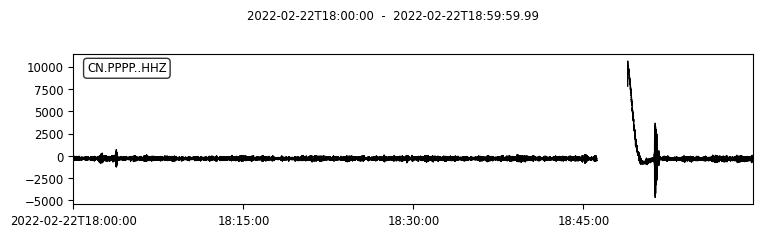

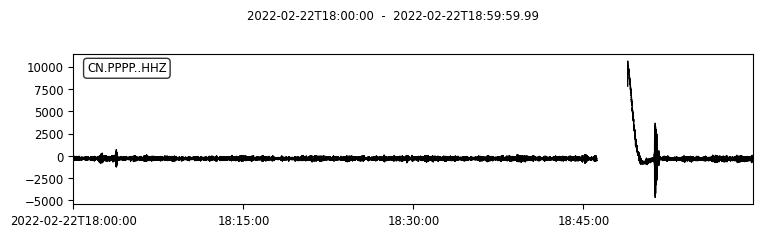

In [24]:
st_final.plot()

In [176]:
st = obspy.read("data/2023/01/01/CN.PPPP._20230101_000000.seed")
st2 = obspy.read("data/2023/01/01/CN.PPPP._20230101_020000.seed")

#st_vacio = obspy.Stream.clear

#st_vacio

#st[2]+st_vacio

st2 = st.select(component='Z')

st2[0].resample(sampling_rate = 100).data.dtype


#st2.plot()
#st2.stats

#st2 = st[2]
#st2.stats 
#st[2].data.dtype

dtype('float64')

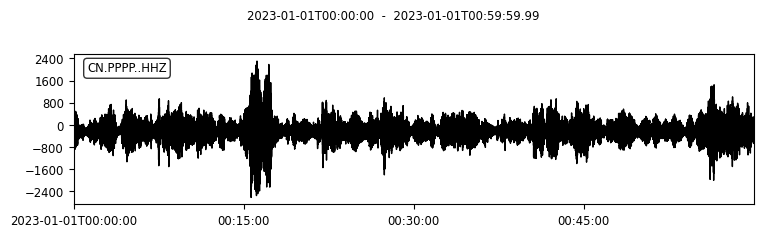

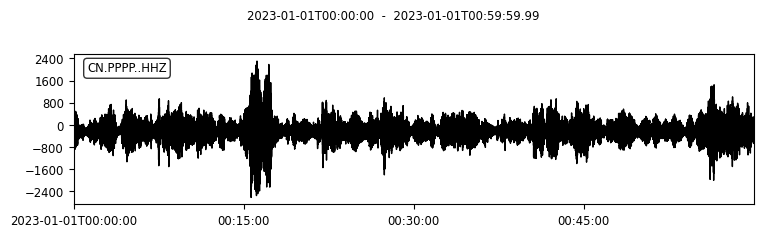

In [177]:
st[2].stats

st[2].data.dtype

st[2].plot()


In [50]:
st_hz = (st[2]+st2[2]).resample(sampling_rate=100)
st_hz.stats

#st3_hz = st_hz+st2_hz

         network: CN
         station: PPPP
        location: 
         channel: HHZ
       starttime: 2023-01-01T00:00:00.000000Z
         endtime: 2023-01-01T02:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 1080000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1764, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 2737152})
      processing: ["ObsPy 1.4.1: resample(no_filter=True::sampling_rate=100::strict_length=False::window='hann')"]

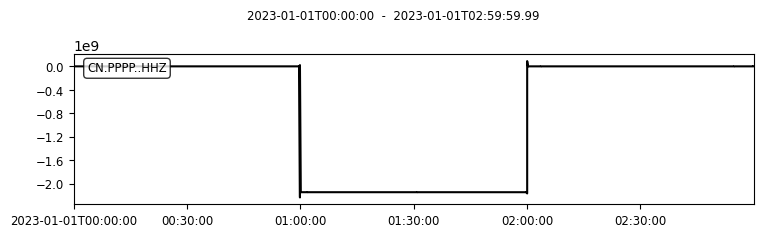

c:\Users\LENOVO\OneDrive\Documentos\Estancia de Investigación\Estancia_Maestría\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


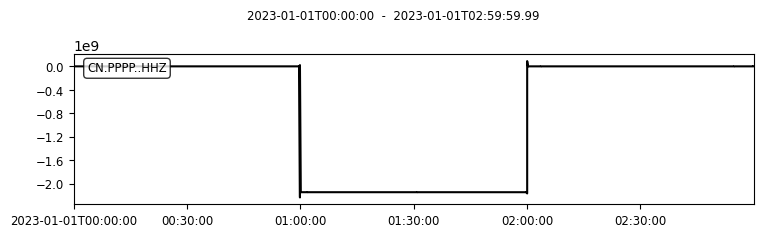

In [51]:
st_hz.plot()

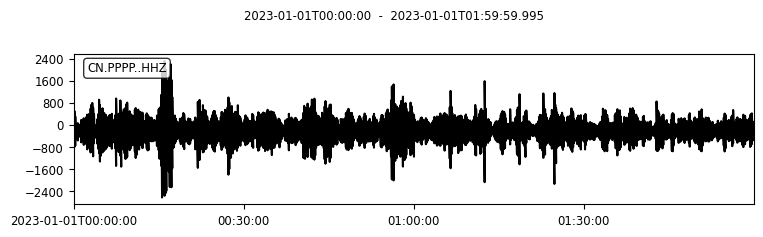

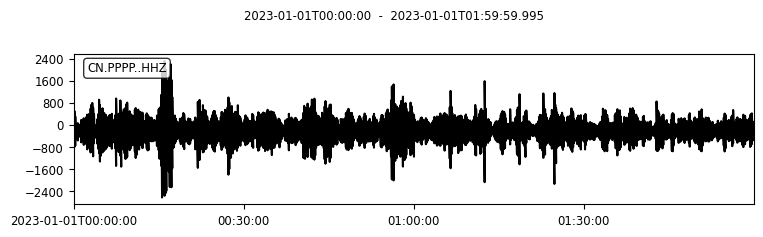

In [22]:
st3_hz.plot()

In [14]:
st_hz_smple = st_hz.copy()

In [23]:
st_hz_smple.resample(sampling_rate=100)

CN.PPPP..HHZ | 2023-01-01T00:00:00.000000Z - 2023-01-01T00:59:59.990000Z | 100.0 Hz, 360000 samples

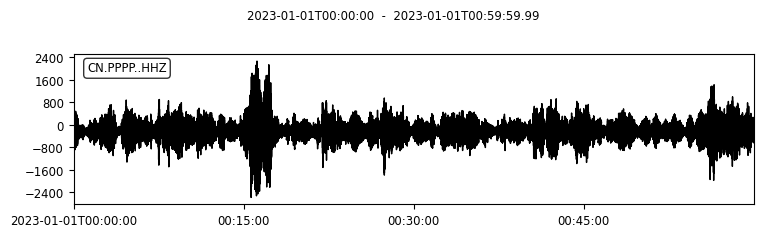

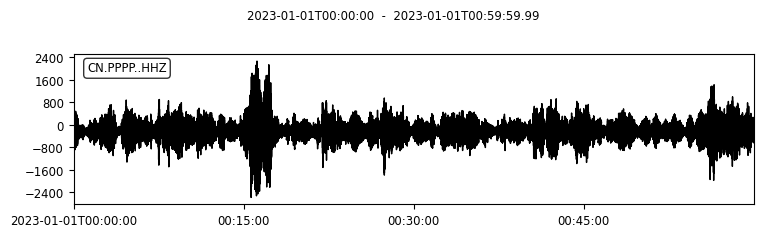

In [24]:
st_hz_smple.plot()

In [154]:
st = obspy.read("data/clean_data/2022/CN_PPPP_HHZ_2022_04_09.seed")
#st2 = obspy.read("data/clean_data/2022/CN_PPPP_HHZ_20220102.sac")

In [168]:
type(st[0].stats.endtime.hour)

int

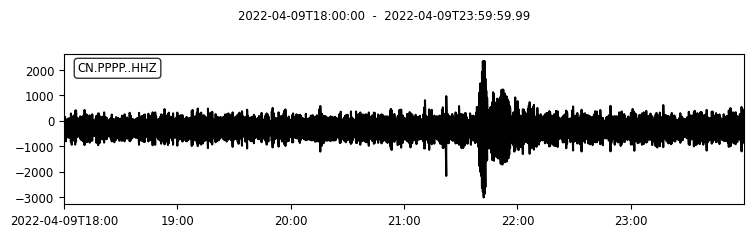

2160000

In [61]:
st.plot()
len(st[0])

In [152]:
array= np.zeros(360000)
array = array.astype(float)
st2 = obspy.core.trace.Trace(data = array)

In [149]:
st2.stats.starttime="2022-04-09T00:00:00.00Z"
st2.id = "CN.PPPP..HHZ"
st2.stats.delta = 0.01
st2.sampling_rate = 100

In [150]:
st2.stats

         network: CN
         station: PPPP
        location: 
         channel: HHZ
       starttime: 2022-04-09T00:00:00.000000Z
         endtime: 2022-04-09T00:59:59.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 360000
           calib: 1.0

In [151]:
st_final = obspy.Trace.__add__(self=st2, trace=st[0] , fill_value=0.0)

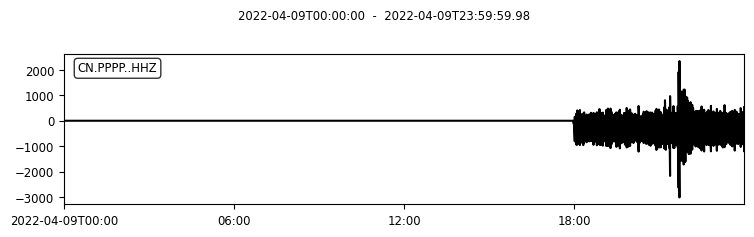

8639999

In [84]:
st_final.plot()
len(st_final)

In [141]:
array= np.zeros(360000)

array = array.astype(float)

st1 = obspy.core.trace.Trace(data = array)
st1.stats.starttime="2022-04-09T00:00:00Z"
#st1.stats.endtime = "2022-04-09T23:59:59.99Z"
st1.id = "CN.PPPP..HHZ"
st1.stats.delta = 0.01
st1.sampling_rate = 100

st2 = obspy.core.trace.Trace(data = array)
st2.stats.starttime="2022-04-09T23:00:00.00Z"
st2.id = "CN.PPPP..HHZ"
st2.stats.delta = 0.01
st2.sampling_rate = 100
st_final = obspy.Trace.__add__(self=st1, trace=st2 , fill_value=0.0)



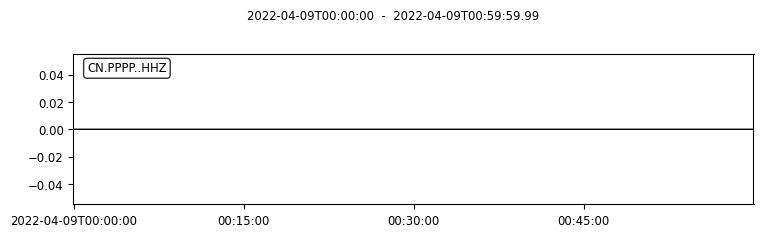

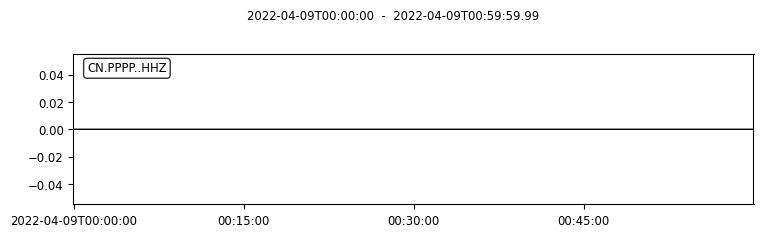

In [140]:
st1.plot()

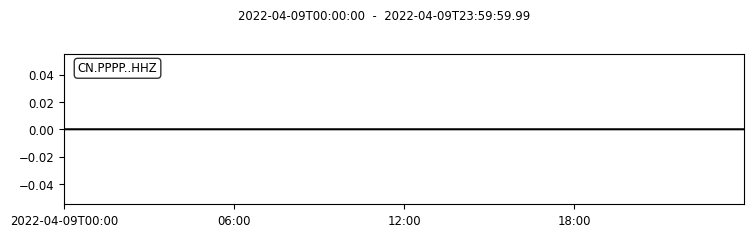

8640000

In [142]:
st_final = obspy.Trace.__add__(self=st1, trace=st2 , fill_value=0.0)
st_final.plot()
len(st_final)

In [99]:
st_final

CN.PPPP..HHZ | 2022-04-09T00:00:00.000000Z - 2022-04-09T23:59:59.980000Z | 100.0 Hz, 8639999 samples